# 課題2 音響効果の付与
エコー，ピッチシフト，テンポシフトを時間領域および周波数領域で実現する


## 必要なライブラリのインポートおよび雑多な変数の設定
おまじない

In [40]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal
import os


eps = 1e-10     ### 「めっちゃ小さい数」として使う便利な値
plt.rcParams.update({
    ####### matplotlibでグラフを出力するときの設定
    'font.size' : 18,     ### フォントサイズ
    'font.family': ['Times New Roman']   ### フォントの種類
})
duration = 10   ### この課題で扱う曲の長さ[sec.]
fft_num = 8192  ### FFT長(librosaのSTFTでのFFTを行う1サンプルのデフォルト値)

## WAVファイルから波形の読み込み
input_fileは読み込みたいファイルに合わせて適宜変更

In [41]:
####### 読み込むファイル名(適宜変更)
input_file = "wav_data" + os.sep + "input" + os.sep + "sakura.wav"

####### 書き出し先のディレクトリ
output_dir = "wav_data" + os.sep + "output" + os.sep


wave, sr = librosa.core.load(input_file)  ### load input wav

####### waveをdurationの長さ分だけ取り出す
wave_length = duration*sr
wave = wave[:wave_length]

print(f"waveのサイズ:{wave.shape}\n時間:{duration} sec\nサンプリングレート{sr}")

waveのサイズ:(220500,)
時間:10 sec
サンプリングレート22050


## 課題2.1 時間領域でエコーをかける
元の信号に対し，エコーのかかった信号を作成する．

### matplotlibで波形の表示

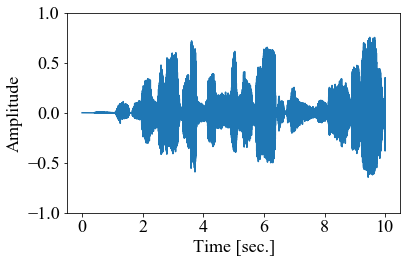

In [42]:
t = np.arange(0, wave.shape[0]/sr, 1/sr)  ### x axis [sec.]
plt.plot(t, wave)           ### x軸: t, y軸: wave
plt.xlabel("Time [sec.]")   ### x軸ラベル
plt.ylabel("Amplitude")     ### y軸ラベル
plt.ylim([-1, 1])           ### y軸表示範囲
plt.tight_layout()          ### 図のサイズをなんかいい感じにする
plt.show()                  ### グラフの表示

### waveにエコーをかけたwave_echo1の作成（記述）

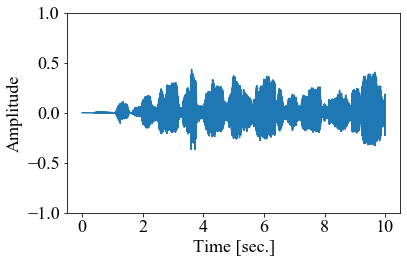

In [43]:
####### waveと同じ中身のnumpy配列を作成
wave_echo1 = wave.copy()
delay = 1.5     ### エコーの遅れる長さ(秒)
delay_pow = 0.7             ### エコーの音量の倍率（ゲイン）


####### WRITE HERE ######################################################
###### delay秒遅れるとしたときのサンプル数
###### int型にキャストすること
delay_length = int(delay*sr)

####### waveのdelay_length後から最後までのデータに対して，
####### delay_length個分前の音を加える
for i in range(delay_length, wave_length):
    wave_echo1[i] += delay_pow*wave[i-delay_length]
    wave_echo1[i] *= 0.5    ### 音割れ防止のための調整

#########################################################################

t = np.arange(0, wave_echo1.shape[0]/sr, 1/sr)  ### x axis [sec.]
plt.plot(t, wave_echo1)           ### x軸: t, y軸: wave
plt.xlabel("Time [sec.]")   ### x軸ラベル
plt.ylabel("Amplitude")     ### y軸ラベル
plt.ylim([-1, 1])           ### y軸表示範囲
plt.tight_layout()          ### 図のサイズをなんかいい感じにする
plt.show()                  ### グラフの表示

####### wave_echo1をout2_echo1.wavとして保存
sf.write(output_dir + os.sep + "out2_echo1.wav", wave_echo1, sr)

## 課題2.2 周波数領域でエコーをかける
STFTした領域でエコーをかけ，時間領域でかけたものと比較する．

### STFTとカラーマップの表示

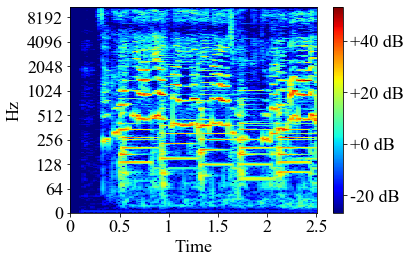

STFT後のサイズ:縦4097，横108


In [44]:
x = librosa.core.stft(wave, n_fft=fft_num, hop_length=fft_num//4)  ### STFT

####### カラーマップの描画
x_abs = np.abs(x)  ### 振幅成分の取り出し
x_abs_db = librosa.core.amplitude_to_db(x_abs)  ### db単位へ変換
librosa.display.specshow(x_abs_db, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

print(f"STFT後のサイズ:縦{x.shape[0]}，横{x.shape[1]}")

### xにエコーをかけたx_echoの作成（記述）

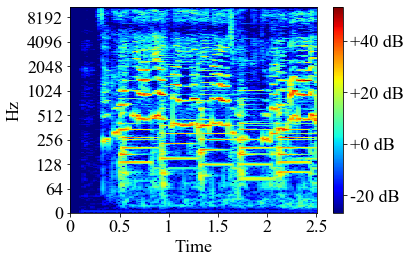

In [45]:
####### xと同じ中身のnumpy行列を作成
x_echo = x.copy()

sample_per_sec = x_echo.shape[1]//duration  ### STFTカラーマップの1秒当たりのサンプル数
delay_pow = 0.7             ### エコーの音量の倍率（ゲイン）

####### WRITE HERE ######################################################
###### delay秒遅れるとしたときのサンプル数
###### int型にキャストすること
delay_length = int(delay*sample_per_sec)

####### xのdelay_length後から最後までに対して，
####### delay_length個分前の値を加える
for j in range(delay_length, x.shape[1]):
    for i in range(x.shape[0]):
        x_echo[i, j] += delay_pow*x[i, j-delay_length]

#########################################################################

####### カラーマップの描画
x_abs = np.abs(x)  ### 振幅成分の取り出し
x_abs_db = librosa.core.amplitude_to_db(x_abs)  ### db単位へ変換
librosa.display.specshow(x_abs_db, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

### x_echoをiSTFTにより波形成分に変換（記述）

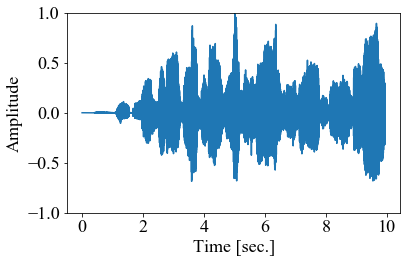

In [46]:
####### iSTFTにより波形に戻す
wave_echo2 = librosa.core.istft(x_echo)

####### WRITE HERE ######################################################
####### wave_echo2の表示
t = np.arange(0, wave_echo2.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave_echo2)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave_echo2をout2_echo2.wavとして保存
sf.write(output_dir + os.sep + "out2_echo2.wav", wave_echo2, sr)

#########################################################################

## 課題3.1 時間領域でテンポ(?)シフト
元の信号を0.5倍速，1.5倍速したものをそれぞれ作成

### waveを0.5倍速したwave_fast1_05を作成

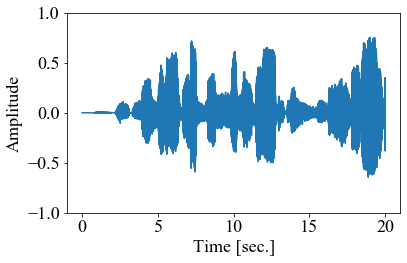

In [47]:
####### WRITE HERE ######################################################
####### wave_lengthを用いてwave_fast1_05の長さを決める
fast05_len = wave_length*2
wave_fast1_05 = np.zeros([fast05_len])

####### 0.5倍速になるようにwaveの要素を挿入
###### []の中は常にint型になるようにすること
for i in range(fast05_len):
    wave_fast1_05[i] = wave[int(i*0.5)]

####### wave_fast1_05の表示
t = np.arange(0, wave_fast1_05.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave_fast1_05)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave_fast1_05をout2_fast1_05.wavとして保存
sf.write(output_dir + os.sep + "out2_fast1_05.wav", wave_fast1_05, sr)

#########################################################################

### waveを1.5倍速したwave_fast1_15を作成

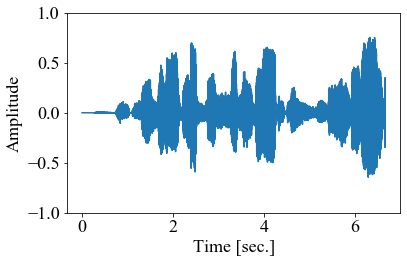

In [48]:
####### WRITE HERE ######################################################
####### wave_lengthを用いてwave_fast1_15の長さを決める
####### fast15_lenはint型になるように注意
fast15_len = int(wave_length/1.5)
wave_fast1_15 = np.zeros([fast15_len])

####### 1.5倍速になるようにwaveの要素を挿入
###### []の中は常にint型になるようにすること
for i in range(fast15_len):
    wave_fast1_15[i] = wave[int(i*1.5)]

####### wave_fast1_15の表示
t = np.arange(0, wave_fast1_15.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave_fast1_15)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave_fast1_15をout2_fast1_15.wavとして保存
sf.write(output_dir + os.sep + "out2_fast1_15.wav", wave_fast1_15, sr)

#########################################################################

## 課題3.2 周波数領域でテンポシフト
時間領域ではテンポを変えると全体の音程（ピッチ）も同時に変わってしまう<br>
（変えない方法もあるが面倒　← 追加課題として調べてもらうのもあり）

### 周波数領域で同様のテンポシフト(0.5倍速，1.5倍速)を行う
### 0.5倍速の時のスペクトルx_fast_05を作成

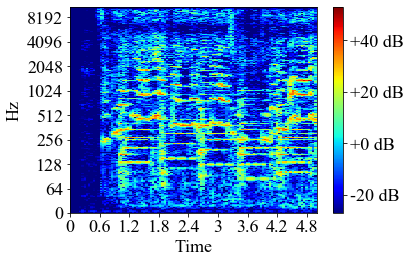

In [49]:
####### もともとのスペクトルxのサイズを取得
####### shape1: 縦（周波数軸），shape1: 横（時間軸）
x_shape1, x_shape2 = x.shape

####### WRITE HERE ######################################################
####### x_fast_05で，xから変わる方の長さを，x_shapeを用いて決める
x_fast_05_len = x_shape2*2
####### np.zeros([縦の長さ, 横の長さ])でx_fast_05を作成
x_fast_05 = np.zeros([x_shape1, x_fast_05_len])

####### x_fast_05の要素を，xをもとに挿入
for i in range(x_fast_05_len):
    x_fast_05[:, i] = x[:, i//2]

#########################################################################

####### カラーマップの描画
x_abs_05 = np.abs(x_fast_05)  ### 振幅成分の取り出し
x_abs_db_05 = librosa.core.amplitude_to_db(x_abs_05)  ### db単位へ変換
librosa.display.specshow(x_abs_db_05, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

### x_fast_05をiSTFTで波形成分に変換

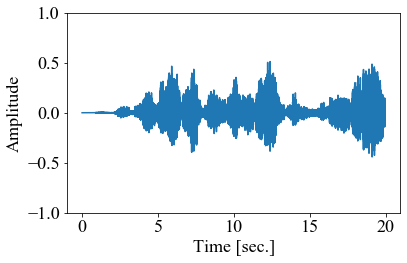

In [50]:
####### WRITE HERE ######################################################
####### iSTFTにより波形に戻す
wave_fast2_05 = librosa.core.istft(x_fast_05)

####### wave_fast2_05の表示
t = np.arange(0, wave_fast2_05.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave_fast2_05)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave_fast2_05をout2_fast2_05.wavとして保存
sf.write(output_dir + os.sep + "out2_fast2_05.wav", wave_fast2_05, sr)

#########################################################################

### 1.5倍速の時のスペクトルx_fast_15を作成

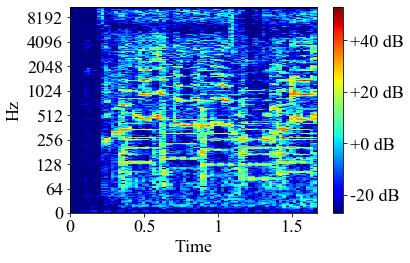

In [51]:
####### WRITE HERE ######################################################
####### x_fast_15で，xから変わる方の長さを，x_shapeを用いて決める
x_fast_15_len = int(x_shape2/1.5)
####### np.zeros([縦の長さ, 横の長さ])でx_fast_15を作成
x_fast_15 = np.zeros([x_shape1, x_fast_15_len])

####### x_fast_15の要素を，xをもとに挿入
for i in range(x_fast_15_len):
    x_fast_15[:, i] = x[:, int(i*1.5)]

#########################################################################

####### カラーマップの描画
x_abs_15 = np.abs(x_fast_15)  ### 振幅成分の取り出し
x_abs_db_15 = librosa.core.amplitude_to_db(x_abs_15)  ### db単位へ変換
librosa.display.specshow(x_abs_db_15, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

### x_fast_15をiSTFTで波形成分に変換

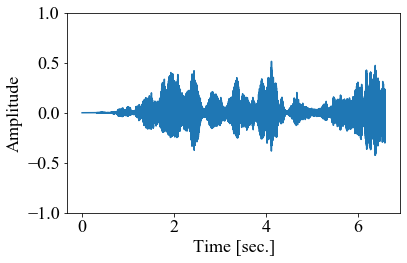

In [52]:
####### WRITE HERE ######################################################
####### iSTFTにより波形に戻す
wave_fast2_15 = librosa.core.istft(x_fast_15)

####### wave_fast2_15の表示
t = np.arange(0, wave_fast2_15.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave_fast2_15)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave_fast2_15をout2_fast2_15.wavとして保存
sf.write(output_dir + os.sep + "out2_fast2_15.wav", wave_fast2_15, sr)

#########################################################################

## 課題3.3 周波数領域でピッチシフト
逆に，テンポを変えずに音程（ピッチ）だけを0.5倍，1.5倍にしたい

### ピッチ0.5倍の時のスペクトルx_pitch_05を作成

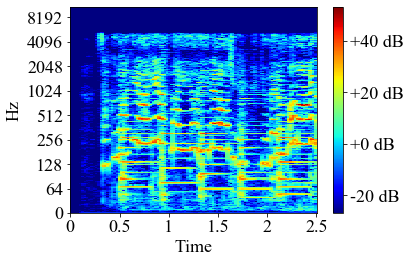

In [53]:
####### x_pitch_05のサイズはxと同じ
####### ↓ np.zeros([x_shape1, x_shape2])と同じ意味
x_pitch_05 = np.zeros_like(x)

####### WRITE HERE ######################################################
####### xのすべての値を，周波数0.5倍にした位置へ移動させる
####### x_pitch_05の周波数が半分より大きい部分は，
####### 参照できるデータがないので0のままにしておく
for i in range(x_shape1//2):
    for j in range(x_shape2):
        x_pitch_05[i, j] = x[i*2, j]

#########################################################################

####### カラーマップの描画
x_abs_05 = np.abs(x_pitch_05)  ### 振幅成分の取り出し
x_abs_db_05 = librosa.core.amplitude_to_db(x_abs_05)  ### db単位へ変換
librosa.display.specshow(x_abs_db_05, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

### x_pitch_05をiSTFTで波形成分に変換

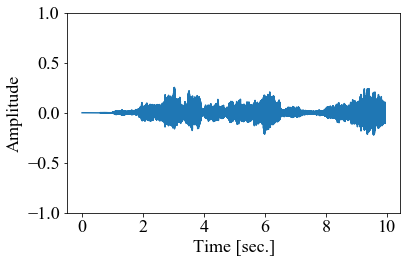

In [54]:
####### WRITE HERE ######################################################
####### iSTFTにより波形に戻す
wave_pitch_05 = librosa.core.istft(x_pitch_05)

####### wave_pitch_05の表示
t = np.arange(0, wave_pitch_05.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave_pitch_05)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave_pitch_05をout2_pitch_05.wavとして保存
sf.write(output_dir + os.sep + "out2_pitch_05.wav", wave_pitch_05, sr)

#########################################################################

### ピッチ1.5倍の時のスペクトルx_pitch_15を作成

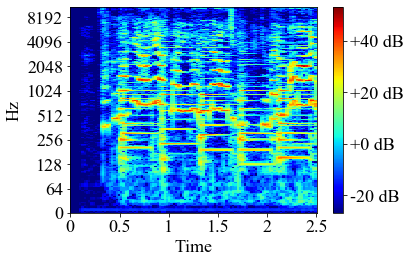

In [55]:
####### WRITE HERE ######################################################
####### x_pitch_15のサイズはxと同じ
x_pitch_15 = np.zeros_like(x)

####### xのすべての値を，周波数1.5倍にした位置へ移動させる
for i in range(x_shape1):
    for j in range(x_shape2):
        x_pitch_15[i, j] = x[int(i/1.5), j]

#########################################################################

####### カラーマップの描画
x_abs_15 = np.abs(x_pitch_15)  ### 振幅成分の取り出し
x_abs_db_15 = librosa.core.amplitude_to_db(x_abs_15)  ### db単位へ変換
librosa.display.specshow(x_abs_db_15, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

### x_pitch_15をiSTFTで波形成分に変換

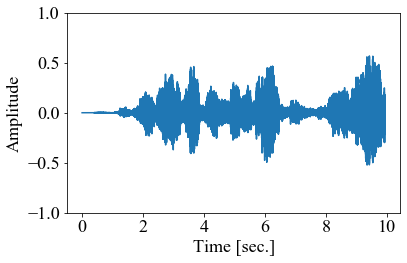

In [56]:
####### WRITE HERE ######################################################
####### iSTFTにより波形に戻す
wave_pitch_15 = librosa.core.istft(x_pitch_15)

####### wave_pitch_15の表示
t = np.arange(0, wave_pitch_15.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave_pitch_15)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave_pitch_15をout2_pitch_15.wavとして保存
sf.write(output_dir + os.sep + "out2_pitch_15.wav", wave_pitch_15, sr)

#########################################################################

## 課題3.4 周波数領域での精度の変化
STFTの分解能を考えることで，周波数領域でのテンポ/ピッチシフトで<br>
もっときれいな出力結果を得られる可能性がある<br>
（0.5倍のときに声の子音に変なエコーがかかっているのは，時間軸での切り取る長さ（分解能）が原因）<br><br>
分解能には，課題2.2で行ったSTFTにおけるn_fftの値(fft_num)が影響する．<br>
これはFFT長などとも呼ばれ，時間軸および周波数軸の長さ，すなわち細かさに影響する<br>
（詳細はググってください）．

### fft_numを小さく（xの時の1/4）してSTFTを行う


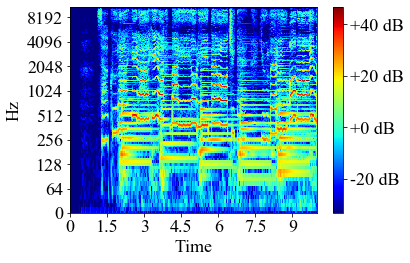

STFT後のサイズ:縦1025，横431


In [57]:
####### WRITE HERE ######################################################
####### fft_numの1/4の長さでfft_num2を設定
fft_num2 = fft_num//4

#########################################################################
x2 = librosa.core.stft(wave, n_fft=fft_num2, hop_length=fft_num2//4)  ### STFT

####### カラーマップの描画
x_abs2 = np.abs(x2)  ### 振幅成分の取り出し
x_abs_db2 = librosa.core.amplitude_to_db(x_abs2)  ### db単位へ変換
librosa.display.specshow(x_abs_db2, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

####### x2のサイズを表示（xの時と変わっている）
print(f"STFT後のサイズ:縦{x2.shape[0]}，横{x2.shape[1]}")

### 時間分解能を上げることでテンポシフトの精度を向上させてみる

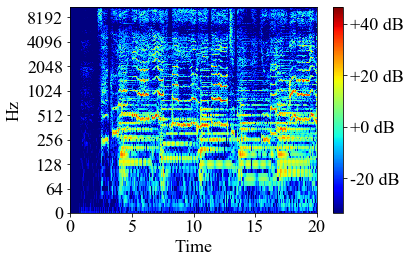

In [58]:
####### x2のサイズを取得
####### shape1: 縦（周波数軸），shape1: 横（時間軸）
x2_shape1, x2_shape2 = x2.shape

####### WRITE HERE ######################################################
####### x2_fast_05で，x2から変わる方の長さを，x2_shapeを用いて決める
x2_fast_05_len = x2_shape2*2
####### np.zeros([縦の長さ, 横の長さ])でx2_fast_05を作成
x2_fast_05 = np.zeros([x2_shape1, x2_fast_05_len])

####### x2_fast_05の要素を，x2をもとに挿入
for i in range(x2_fast_05_len):
    x2_fast_05[:, i] = x2[:, i//2]

#########################################################################

####### カラーマップの描画
x_abs_05 = np.abs(x2_fast_05)  ### 振幅成分の取り出し
x_abs_db_05 = librosa.core.amplitude_to_db(x_abs_05)  ### db単位へ変換
librosa.display.specshow(x_abs_db_05, cmap='jet', sr=sr, x_axis='time', y_axis='log')  ### スペクトログラムを表示(y軸を対数軸に変換)
plt.colorbar(format='%+2.0f dB')    ### カラーバーの表示
plt.tight_layout()                  ### 図のサイズをなんかいい感じにする
plt.show()                          ### グラフの表示

### x2_fast_05をiSTFTで波形成分に変換

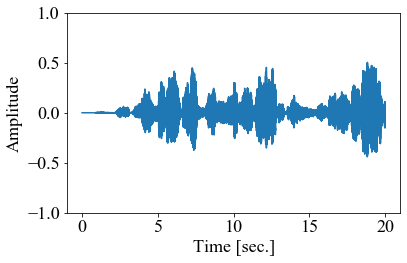

In [60]:
####### WRITE HERE ######################################################
####### iSTFTにより波形に戻す
wave2_fast_05 = librosa.core.istft(x2_fast_05)

####### wave2_fast_05の表示
t = np.arange(0, wave2_fast_05.shape[0]/sr, 1/sr)  ## x axis [sec.]
plt.plot(t, wave2_fast_05)
plt.xlabel("Time [sec.]")
plt.ylabel("Amplitude")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

####### wave2_fast_05をout2_fast3_05.wavとして保存
sf.write(output_dir + os.sep + "out2_fast3_05.wav", wave2_fast_05, sr)

#########################################################################